In [3]:
import numpy as np
import matplotlib.pyplot as plt

from meta_training import (
    EvaluationConfig,
    MetaTrainingConfig,
    evaluate_memory_module,
    resolve_device,
    run_meta_training,
)


In [4]:
training_config = MetaTrainingConfig(
    device_preference="cuda",
    key_dim=16,
    val_dim=16,
    context_dim=5,
    seq_len=50,
    num_sequences=500,
    batch_size=10,
    recall_window=1,
    output_corr=0.5,
    inner_optimizer_kwargs={"beta1": 0.95, "beta2": 0.99, "epsilon": 1e-8},
    outer_optimizer_kwargs={"lr": 0.01},
    log_every_sequences=50,
)

actual_device = resolve_device(training_config.device_preference)
print(f"--- Starting Training on {actual_device} ---")
artifacts = run_meta_training(training_config)
print("--- Training complete ---")


--- Starting Training on cuda ---
Epoch 10 | Avg Outer Loss: 3.9066
  Sample Hyperparams -> LR: 0.1110
Epoch 50 | Avg Outer Loss: 3.9698
  Sample Hyperparams -> LR: 0.0964
Epoch 100 | Avg Outer Loss: 3.9073
  Sample Hyperparams -> LR: 0.1192
Epoch 150 | Avg Outer Loss: 3.8746
  Sample Hyperparams -> LR: 0.1169
Epoch 200 | Avg Outer Loss: 3.9084
  Sample Hyperparams -> LR: 0.1135
Epoch 250 | Avg Outer Loss: 3.8386
  Sample Hyperparams -> LR: 0.0871
Epoch 300 | Avg Outer Loss: 3.8484
  Sample Hyperparams -> LR: 0.0958
Epoch 350 | Avg Outer Loss: 3.8531
  Sample Hyperparams -> LR: 0.0990
Epoch 400 | Avg Outer Loss: 3.8426
  Sample Hyperparams -> LR: 0.0826
Epoch 450 | Avg Outer Loss: 3.8464
  Sample Hyperparams -> LR: 0.0977
Epoch 500 | Avg Outer Loss: 3.8452
  Sample Hyperparams -> LR: 0.0910
--- Training complete ---


--- Recall Accuracy by Offset ---
Offset 0 | Accuracy: 0.088 | Observations: 1000
Offset 1 | Accuracy: 0.056 | Observations: 980
Offset 2 | Accuracy: 0.045 | Observations: 960
Offset 3 | Accuracy: 0.039 | Observations: 940
Offset 4 | Accuracy: 0.036 | Observations: 920
Offset 5 | Accuracy: 0.032 | Observations: 900
Offset 6 | Accuracy: 0.028 | Observations: 880
Offset 7 | Accuracy: 0.027 | Observations: 860
Offset 8 | Accuracy: 0.025 | Observations: 840
Offset 9 | Accuracy: 0.024 | Observations: 820
Offset 10 | Accuracy: 0.025 | Observations: 800
Offset 11 | Accuracy: 0.026 | Observations: 780
Offset 12 | Accuracy: 0.025 | Observations: 760
Offset 13 | Accuracy: 0.024 | Observations: 740
Offset 14 | Accuracy: 0.025 | Observations: 720
Offset 15 | Accuracy: 0.024 | Observations: 700
Offset 16 | Accuracy: 0.022 | Observations: 680
Offset 17 | Accuracy: 0.023 | Observations: 660
Offset 18 | Accuracy: 0.023 | Observations: 640
Offset 19 | Accuracy: 0.023 | Observations: 620
Offset 20 | Acc

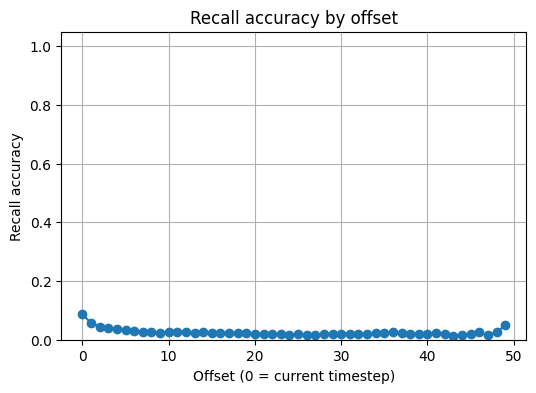

In [4]:
evaluation_config = EvaluationConfig(
    seq_len=training_config.seq_len,
    num_sequences=20,
    key_dim=training_config.key_dim,
    val_dim=training_config.val_dim,
    context_dim=training_config.context_dim,
    output_corr=training_config.output_corr,
)

results = evaluate_memory_module(artifacts.memory_module, evaluation_config)
results_cpu = results.cpu()
offsets = results_cpu.offsets.numpy()
accuracies = results_cpu.mean_accuracy.numpy()
counts = results_cpu.counts.numpy()

valid_mask = counts > 0
print("--- Recall Accuracy by Offset ---")
for offset, accuracy, count in zip(offsets[valid_mask], accuracies[valid_mask], counts[valid_mask]):
    print(f"Offset {int(offset)} | Accuracy: {accuracy:.3f} | Observations: {int(count)}")

plt.figure(figsize=(6, 4))
plt.plot(offsets, accuracies, marker="o")
plt.xlabel("Offset (0 = current timestep)")
plt.ylabel("Recall accuracy")
plt.title("Recall accuracy by offset")
plt.ylim(0.0, 1.05)
plt.grid(True)
plt.show()


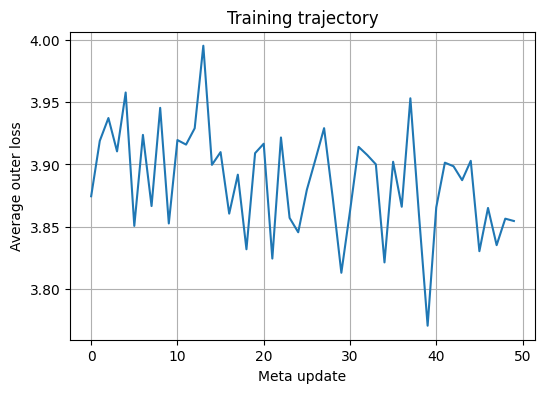

In [5]:
plt.figure(figsize=(6, 4))
plt.plot(np.arange(len(artifacts.outer_losses)), artifacts.outer_losses)
plt.xlabel("Meta update")
plt.ylabel("Average outer loss")
plt.title("Training trajectory")
plt.grid(True)
plt.show()
